In [6]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy.ma as ma
from topoPy import *

In [17]:
# ICON grid file
df = nc.Dataset('../data/icon_grid_0012_R02B04_G.nc')
print(df.variables)

# store the lat,lon of the vertices and the centre of each triangular grid
clat = ma.getdata(df.variables['clat'][:])
clat_vertices = ma.getdata(df.variables['clat_vertices'][:])
clon = ma.getdata(df.variables['clon'][:])
clon_vertices = ma.getdata(df.variables['clon_vertices'][:])

# change to degrees
clat, clat_vertices = clat*(180/np.pi), clat_vertices*(180/np.pi)
clon, clon_vertices = clon*(180/np.pi), clon_vertices*(180/np.pi)

{'clon': <class 'netCDF4._netCDF4.Variable'>
float64 clon(cell)
    long_name: center longitude
    units: radian
    standard_name: grid_longitude
    bounds: clon_vertices
unlimited dimensions: 
current shape = (20480,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'clat': <class 'netCDF4._netCDF4.Variable'>
float64 clat(cell)
    long_name: center latitude
    units: radian
    standard_name: grid_latitude
    bounds: clat_vertices
unlimited dimensions: 
current shape = (20480,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'clon_vertices': <class 'netCDF4._netCDF4.Variable'>
float64 clon_vertices(cell, nv)
    units: radian
unlimited dimensions: 
current shape = (20480, 3)
filling on, default _FillValue of 9.969209968386869e+36 used, 'clat_vertices': <class 'netCDF4._netCDF4.Variable'>
float64 clat_vertices(cell, nv)
    units: radian
unlimited dimensions: 
current shape = (20480, 3)
filling on, default _FillValue of 9.969209968386869e+36 used, 'vlon

In [3]:
# pick the cell around the reference lat,lon
def pickCell(lat_ref, lon_ref, clat, clon):
    index = np.nonzero((np.abs(clat-lat_ref)<=1) & 
                       (np.abs(clon-lon_ref)<=1))[0]
    
    print("index = ", index)
    # pick the centre closest to the reference location
    dist = np.abs(clat[index]-lat_ref) + np.abs(clon[index]-lon_ref) 
    print("dist = ", dist)
    ind = np.argmin(dist)
    print("ind = ", ind)
    return index[ind]

In [23]:
#---- pick the ICON cell for a given reference location
# lat_ref = 43
# lon_ref = 42

lat_ref = 46
lon_ref = 8
vid = pickCell(lat_ref,lon_ref,clat,clon) # pick a vertex
# print('Vertex ID:',vid)

#---- set (lon,lat) of the centre of the grid
lon_centre = clon[vid]    # in degrees
lat_centre = clat[vid]    # in degrees
#---- set the periphery of the coarse grid around the centre 
lon_width = 4  # in degrees
lat_width = 4  # in degrees

#---- get the topography around the cell picked

def get_topo(fn):
    df_topo = nc.Dataset(fn)
    lat = ma.getdata(df_topo.variables['lat'][:])
    lon = ma.getdata(df_topo.variables['lon'][:])
    z = ma.getdata(df_topo.variables['topo_recon'][...])
    z_orig = ma.getdata(df_topo.variables['topo'][...])
    
    return lat, lon, z, z_orig, df_topo

index =  [4631]
dist =  [0.72636156]
ind =  0


In [24]:
print(lat_centre, lon_centre)

46.59821710502904 7.871855542954122


[7.62328947 9.53706215 6.3728373 ]


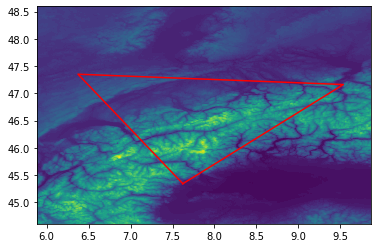

In [25]:
# plot the topo and the ICON triangle
lat, lon, z, z_orig, df_topo = get_topo('../build/output.nc')
plt.contourf(lon,lat,z_orig,60)
x = np.append(clon_vertices[vid,:],clon_vertices[vid,0])
y = np.append(clat_vertices[vid,:],clat_vertices[vid,0])
plt.plot(x,y,'-r')
# plt.show()

print(clon_vertices[vid,:])

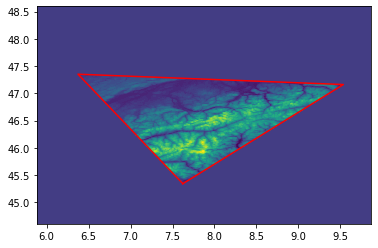

In [26]:
# Plot the topo within the ICON triangle
vi = clat_vertices[vid,:]
vj = clon_vertices[vid,:]
inout = [pointInTriangle(vi,vj,i,j) for i in lat for j in lon]
inout = np.array(inout).reshape(len(lat),len(lon))
z_masked = z_orig*inout

plt.contourf(lon,lat,z_masked,60)
x = np.append(clon_vertices[vid,:],clon_vertices[vid,0])
y = np.append(clat_vertices[vid,:],clat_vertices[vid,0])
plt.plot(x,y,'-r')
plt.show()

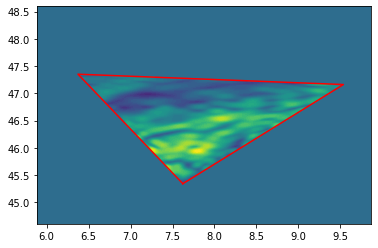

In [29]:
z_recon = ma.getdata(df_topo.variables['topo_recon'][...])
lon = ma.getdata(df_topo.variables['lon'][...])
lat = ma.getdata(df_topo.variables['lat'][...])

plt.contourf(lon,lat,z_recon,60)
x = np.append(clon_vertices[vid,:],clon_vertices[vid,0])
y = np.append(clat_vertices[vid,:],clat_vertices[vid,0])
plt.plot(x,y,'-r')
plt.show()

In [32]:
_, _, z_negWN, _, _ = get_topo('../build/output.nc')

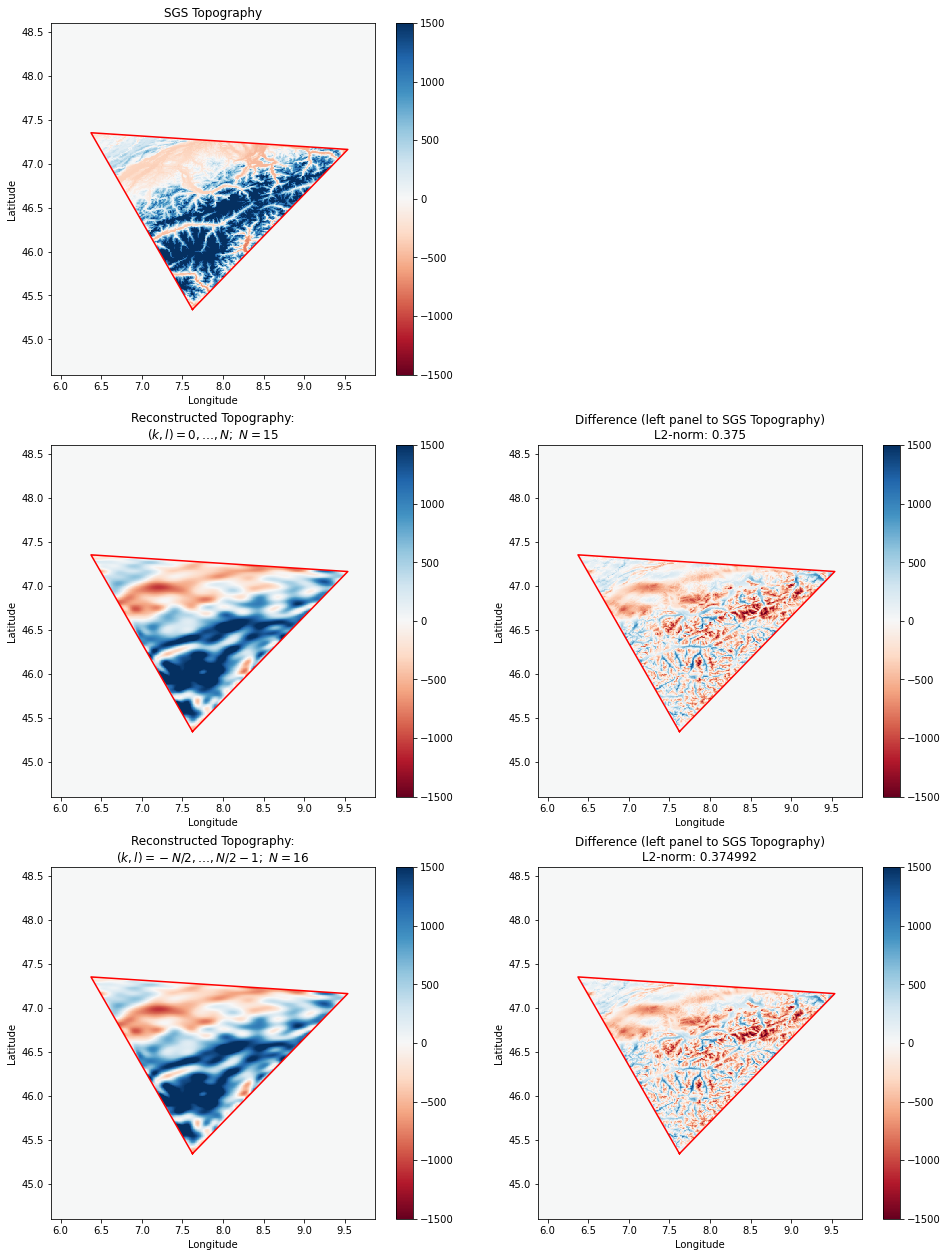

In [36]:
lon_mgrid, lat_mgrid = np.meshgrid(lon,lat)
#---- plot the topography and the spectrum
fig = plt.figure(figsize=(16,22))
vmin=-1500; vmax=1500
# plot the topography within the cell
ax1 = fig.add_subplot(321)
# always use pcolormesh for plotting data with fine structures
sp1 = ax1.pcolormesh(lon_mgrid,lat_mgrid,z_masked,
                     vmin=vmin,vmax=vmax,cmap=mpl.cm.RdBu,shading='auto')
# draw the cell
x = np.append(clon_vertices[vid,:],clon_vertices[vid,0])
y = np.append(clat_vertices[vid,:],clat_vertices[vid,0])
ax1.plot(x,y,'-r')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_title('SGS Topography')
fig.colorbar(sp1,ax=ax1)

# plot the reconstructed data
ax3 = fig.add_subplot(323)
sp3 = ax3.pcolormesh(lon_mgrid,lat_mgrid,z_recon,
                     cmap=mpl.cm.RdBu,vmin=vmin,vmax=vmax,shading='auto')
plt.plot(x,y,'-r')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
ax3.set_title('Reconstructed Topography:\n$(k,l)=0,\dots,N;~N=15$')
fig.colorbar(sp3)

# plot the reconstructed data (negWN)
ax5 = fig.add_subplot(325)
sp5 = ax5.pcolormesh(lon_mgrid,lat_mgrid,z_negWN,
                     cmap=mpl.cm.RdBu,vmin=vmin,vmax=vmax,shading='auto')
plt.plot(x,y,'-r')
ax5.set_xlabel('Longitude')
ax5.set_ylabel('Latitude')
ax5.set_title('Reconstructed Topography:\n$(k,l)=-N/2,\dots,N/2-1;~N=16$')
fig.colorbar(sp5)

# plot the reconstructed data
ax4 = fig.add_subplot(324)
sp4 = ax4.pcolormesh(lon_mgrid,lat_mgrid,z_recon-z_masked,
                     cmap=mpl.cm.RdBu,vmin=vmin,vmax=vmax,shading='auto')
plt.plot(x,y,'-r')
ax4.set_xlabel('Longitude')
ax4.set_ylabel('Latitude')
recon_orig_norm = np.linalg.norm(z_recon-z_masked) / z_masked.size
ax4.set_title('Difference (left panel to SGS Topography)\nL2-norm: %.3f' %(recon_orig_norm))
fig.colorbar(sp4)

# plot the reconstructed data (negWN)
ax6 = fig.add_subplot(326)
sp6 = ax6.pcolormesh(lon_mgrid,lat_mgrid,z_negWN-z_masked,
                     cmap=mpl.cm.RdBu,vmin=vmin,vmax=vmax,shading='auto')
plt.plot(x,y,'-r')
ax6.set_xlabel('Longitude')
ax6.set_ylabel('Latitude')
negWN_orig_norm = np.linalg.norm(z_negWN-z_masked) / z_masked.size
ax6.set_title('Difference (left panel to SGS Topography)\nL2-norm: %3f' %(negWN_orig_norm))
fig.colorbar(sp6)

plt.show()
fig.savefig('SGS_spectrum_recons_andes.jpg',dpi=300)

In [80]:
print(z_masked.size)

230400


In [11]:
print(np.linalg.norm(z_recon - z_masked))

65980.86


In [23]:
print(np.linalg.norm(z_recon - z_masked))

48074.168


In [43]:
np.save('/home/ray/Documents/DataWaves/Notebooks/z.npy', z_recon, )
print('saved')

saved
